In [3]:
library(DESeq2)
library(tidyverse)
library(pheatmap)

In [4]:
rs_palette <- c("gray", "#1b9e77", "#7570b3", "#e6ab02")
p_palette <- c('orchid1', 'purple1', 'darkorchid4')
i_palette <- c('grey', 'lightblue', 'darkblue')
t_palette <- c('darkgreen', 'mediumpurple4')
b_palette <- c('#ffd4a3', '#ffaa5e', '#d08159')
y_palette <- c('dodgerblue4', 'springgreen1', '#cc77ff')
r_palette <- viridisLite::viridis(9)

In [5]:
load('1719_filt_model_dds.Rdata')

In [6]:
treatments <- read.csv('1719_treatments.csv')
load('1719_VSD_counts_varFilt.Rdata')

In [6]:
#str(dds_filt)

# Print Numbers for Main Effects

In [74]:
# iterate main effects

get_Ngenes <- function(dds, main_effect, l2fc=0, alpha=0.05){
    main_effect_factors <- list(Irrigation=c('Full', 'RDI', 'None'), 
                            Block=c('A', 'B', 'C'), 
                            Rootstock=c('Ungrafted', '1103P', '3309C', 'SO4'), 
                            Phenology=c('Anthesis', 'Veraison', 'Harvest'),
                            Year=c('2017', '2018', '2019'),
                            Tissue=c('Reproductive', 'Leaf'))
    
    main_effect_test_orders <- list('2'=list(c(2, 1)), 
                                    '3'=list(c(2, 1), c(3, 1), c(3, 2)), 
                                    '4'=list(c(2, 1), c(3, 1), c(4, 1), c(3, 2), c(4, 2), c(4, 3)))
    
    factors <- main_effect_factors[[main_effect]]
    which_test_order <- as.character(length(factors))
    contrasts <- main_effect_test_orders[[which_test_order]]
    
    outputs <- c()
    for (cont in contrasts){ 
        c1 <- factors[cont[1]]
        c2 <- factors[cont[2]]

        # print to confirm right test
        print(str_interp("Testing ${main_effect} contrast: ${c1} vs ${c2}"))
        flush.console()
        
        res <- results(dds, contrast=c(main_effect, c1, c2), lfcThreshold=l2fc, alpha=alpha)
        res <- subset(res, padj < alpha)
        low <- as.data.frame(subset(res, log2FoldChange < -l2fc))
        high <- as.data.frame(subset(res, log2FoldChange > l2fc))
        ngenes <- c(nrow(high), nrow(low))
        outputs <- c(outputs, ngenes)
    }    
    
    return(outputs)
}

In [81]:
get_Ngenes(dds_filt, 'Irrigation', l2fc=2)
get_Ngenes(dds_filt, 'Irrigation', l2fc=1)
get_Ngenes(dds_filt, 'Irrigation', l2fc=0)

[1] "Testing Irrigation contrast: RDI vs Full"
[1] "Testing Irrigation contrast: None vs Full"
[1] "Testing Irrigation contrast: None vs RDI"


[1] 0 0 0 0 0 0

[1] "Testing Irrigation contrast: RDI vs Full"
[1] "Testing Irrigation contrast: None vs Full"
[1] "Testing Irrigation contrast: None vs RDI"


[1] 0 0 0 0 0 0

[1] "Testing Irrigation contrast: RDI vs Full"
[1] "Testing Irrigation contrast: None vs Full"
[1] "Testing Irrigation contrast: None vs RDI"


[1]  405  351  868 1067    7    5

# Explore DEGs

In [7]:
get_sub_genes <- function(dds, contrast, l2fc){
    res <- results(dds, contrast=contrast, lfcThreshold=l2fc, alpha=0.05)
    subset_res <- subset(res, padj < 0.05)
    subset_res <- subset_res[subset_res$log2FoldChange > l2fc | subset_res$log2FoldChange < -l2fc,]
    return(subset_res)
} 

plot_PCA <- function(sub_genes_out, scale=T, center=T, meta){
    varFilt <- vsd_counts_varFilt[, rownames(sub_genes_out)]
    pca <- prcomp(varFilt, scale=scale, center=center)
    PC1var <- formatC(summary(pca)$importance[, 'PC1'][2]*100, digits = 2, format = "f")
    PC2var <- formatC(summary(pca)$importance[, 'PC2'][2]*100, digits = 2, format = "f")
    pca_x <- as.data.frame(pca$x)
    pca_x[,'meta'] <- treatments[, meta]
    
    p <- ggplot(pca_x, aes(PC1, PC2, fill=meta)) + 
         geom_point(shape=21, size=2) + 
         xlab(str_interp("PC1 (${PC1var}%)")) + 
         ylab(str_interp("PC2 (${PC2var}%)")) + 
         theme_bw()
    return(p)
         
}

### Tissue

In [29]:
subTis_0 <- get_sub_genes(dds_filt, c('Tissue', 'Leaf', 'Reproductive'), 0)
subTis_1 <- get_sub_genes(dds_filt, c('Tissue', 'Leaf', 'Reproductive'), 1)
subTis_2 <- get_sub_genes(dds_filt, c('Tissue', 'Leaf', 'Reproductive'), 2)

In [9]:
vsd <- vst(dds_filt, blind=FALSE)

In [30]:
genes <- rownames(subTis_1)

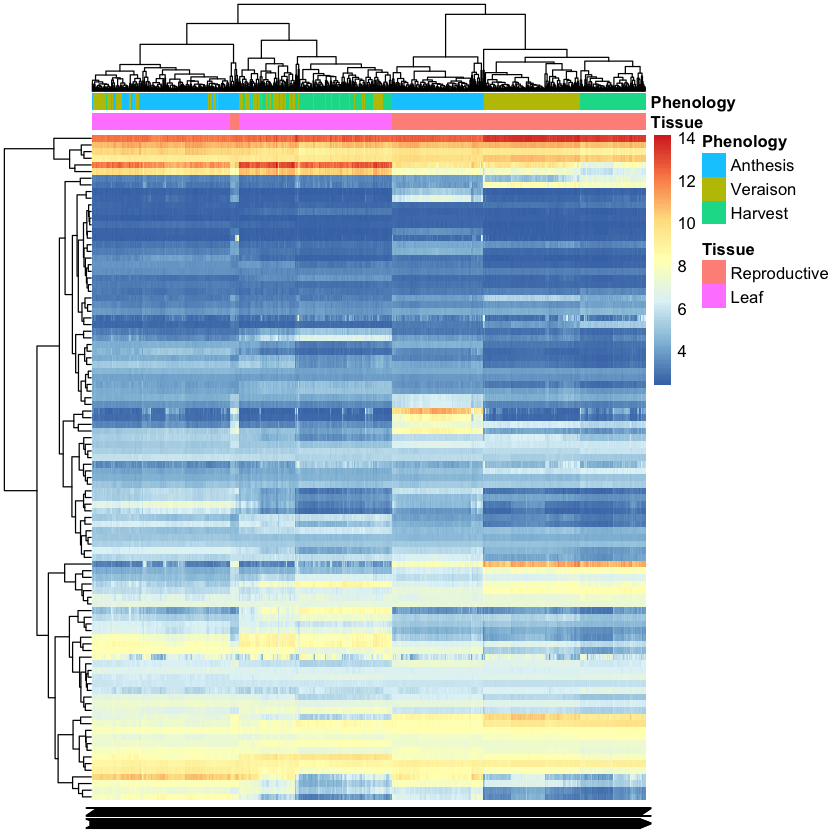

In [34]:
df <- as.data.frame(colData(dds_filt)[,c("Tissue", 'Phenology')])

pheatmap(assay(vsd)[genes,], cluster_rows=TRUE, show_rownames=FALSE, kmeans_k=100,
         cluster_cols=TRUE, annotation_col=df, labels_col=NA)

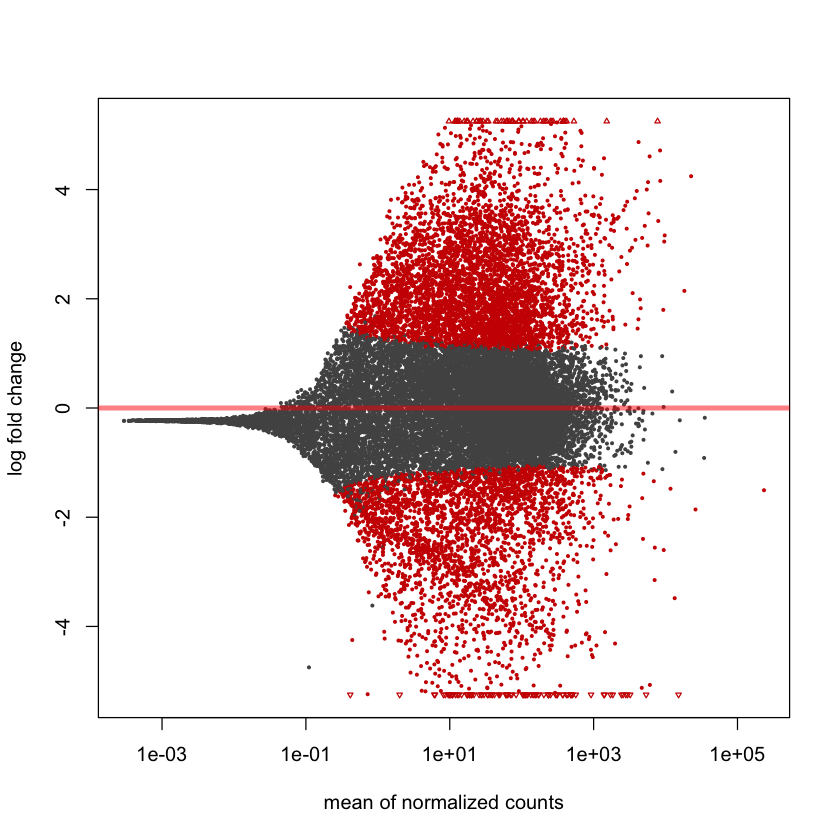

In [36]:
res <- results(dds_filt, contrast=c('Tissue', 'Leaf', 'Reproductive'), lfcThreshold = 1, alpha=0.05)
plotMA(res)

In [37]:
head(subTis_1)

log2 fold change (MLE): Tissue Leaf vs Reproductive 
Wald test p-value: Tissue Leaf vs Reproductive 
DataFrame with 6 rows and 6 columns
                       baseMean     log2FoldChange              lfcSE
                      <numeric>          <numeric>          <numeric>
Vitvi00g00444  4.70956287801214  0.574799404523192 0.0660938969730789
Vitvi00g00447 0.867504108793018 -0.435575367637886  0.118151600842302
Vitvi00g00610  19.4259856746915  -1.85855990006489 0.0643208969091513
Vitvi00g00612  89.7787012887705  -1.83074258987357 0.0630494823845998
Vitvi00g00614  16.2587688721955  -2.13576643300779 0.0675367317092593
Vitvi00g00615  206.275219755215  -1.83779631420696 0.0669157525585735
                           stat                pvalue                  padj
                      <numeric>             <numeric>             <numeric>
Vitvi00g00444  8.69670924014841  3.41647380323139e-18  5.64903938506101e-18
Vitvi00g00447 -3.68658033012395  0.000227287718347875  0.000296470696574405

`geom_smooth()` using formula 'y ~ x'


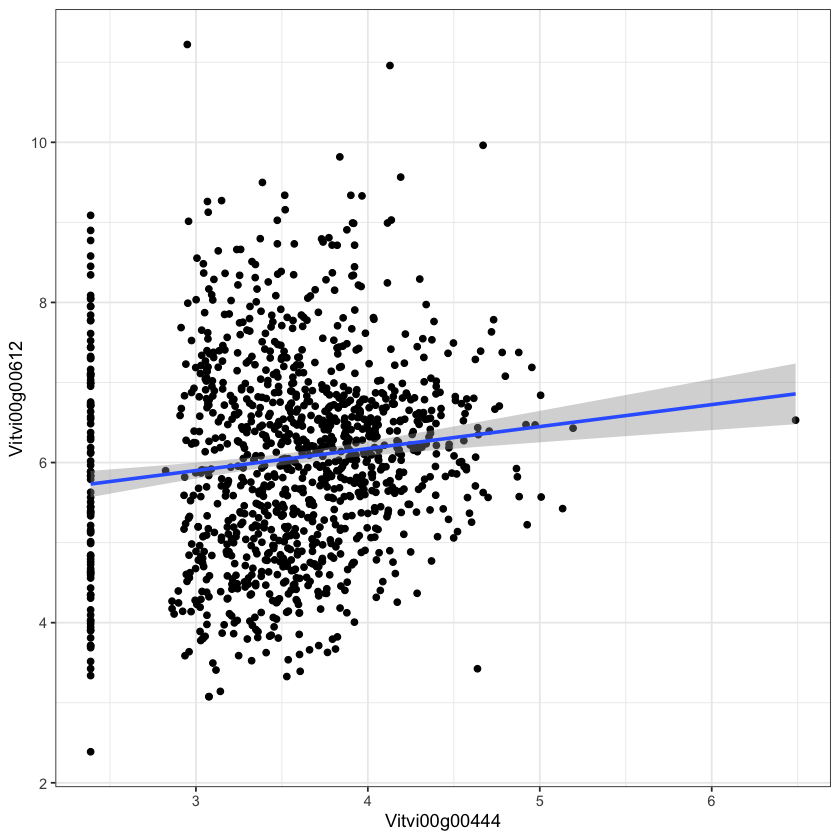

In [53]:
d <- select(vsd_counts_varFilt, rownames(subTis_1))

ggplot(d, aes(Vitvi00g00444, Vitvi00g00612)) + 
  geom_point() + 
  stat_smooth(method='lm') + 
  theme_bw()

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

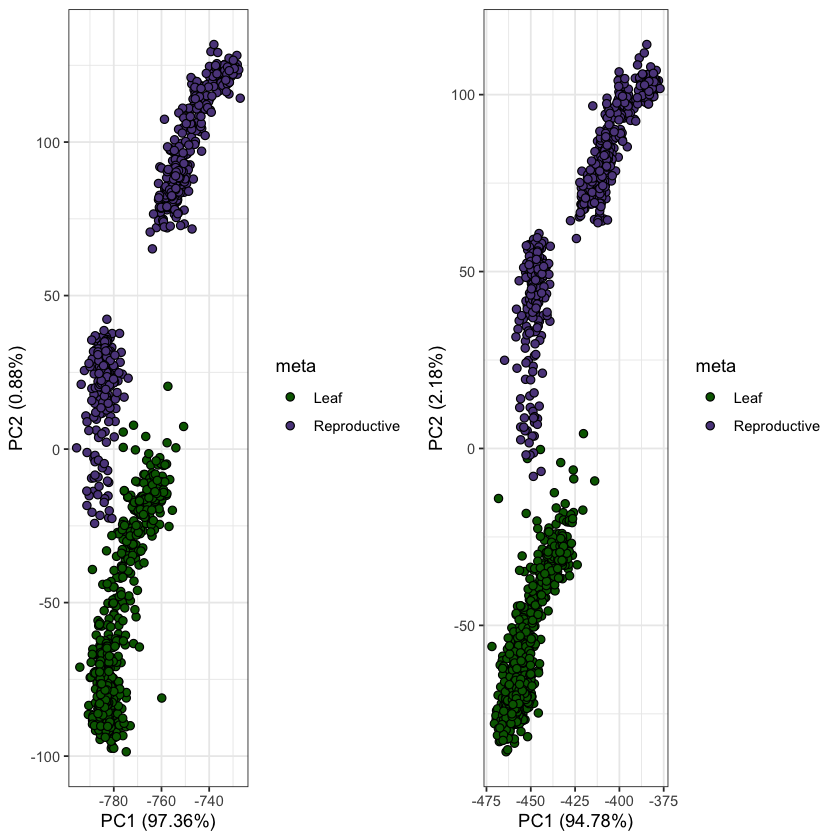

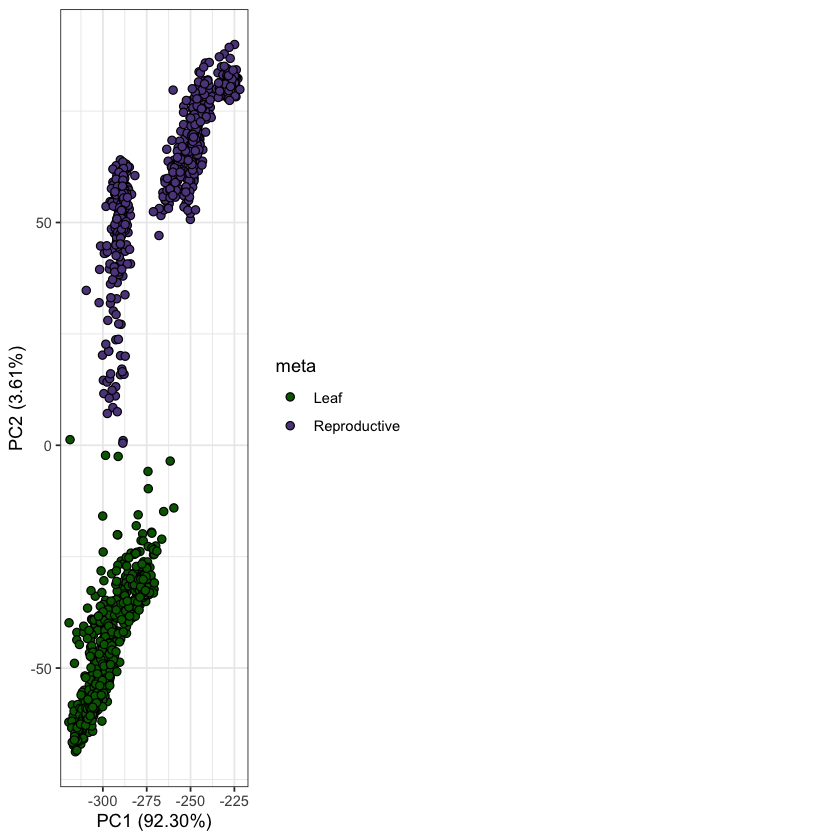

In [196]:
# aa <- plot_PCA(subTis_0, center=F, scale=F, meta='Tissue') + scale_fill_manual(values=t_palette)
# bb <- plot_PCA(subTis_1, center=F, scale=F, meta='Tissue') + scale_fill_manual(values=t_palette)
# cc <- plot_PCA(subTis_2, center=F, scale=F, meta='Tissue') + scale_fill_manual(values=t_palette)

# ggpubr::ggarrange(aa, bb, cc, ncol=2)

## Phenology

In [199]:
subPhen_0 <- get_sub_genes(dds_filt, c('Phenology', 'Anthesis', 'Harvest'), 0)
subPhen_1 <- get_sub_genes(dds_filt, c('Phenology', 'Anthesis', 'Harvest'), 1)
subPhen_2 <- get_sub_genes(dds_filt, c('Phenology', 'Anthesis', 'Harvest'), 2)

$`1`

$`2`

attr(,"class")
[1] "list"      "ggarrange"

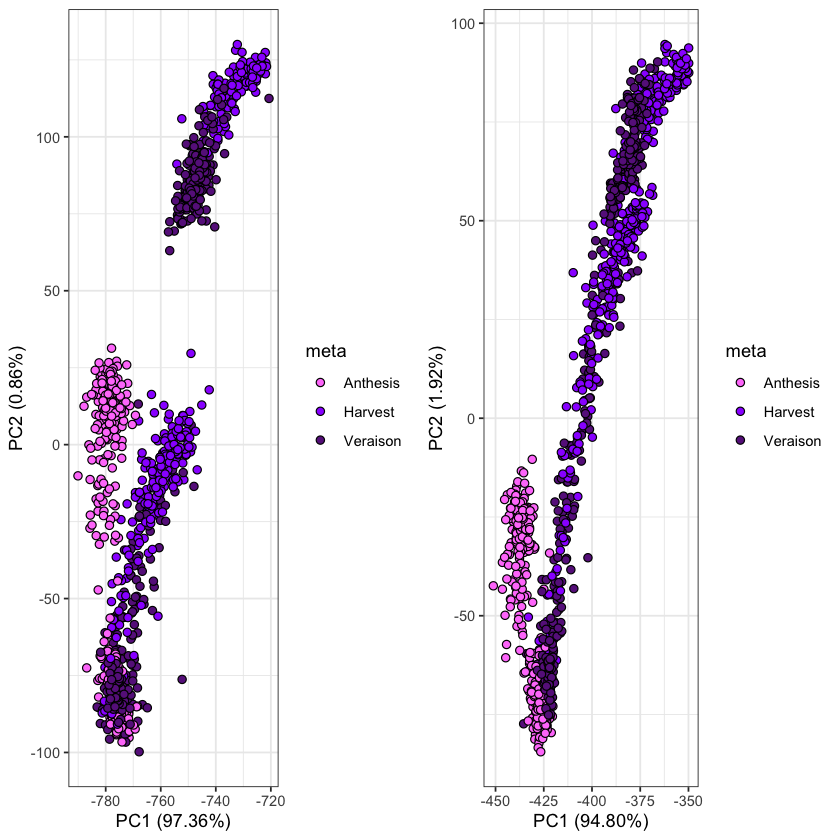

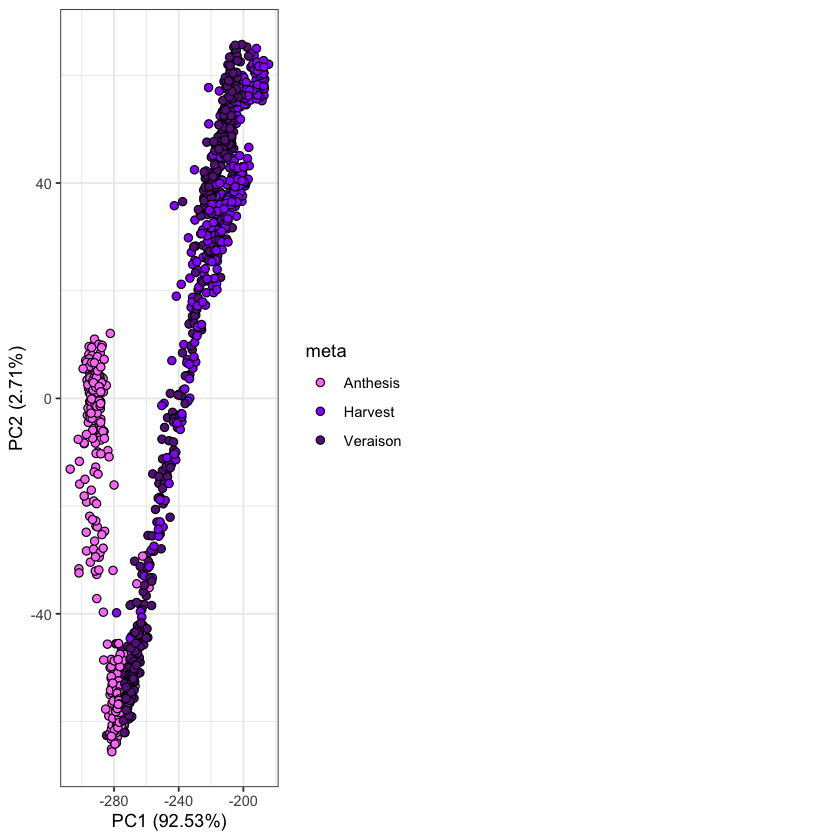

In [200]:
aa <- plot_PCA(subPhen_0, center=F, scale=F, meta='Phenology') + scale_fill_manual(values=p_palette)
bb <- plot_PCA(subPhen_1, center=F, scale=F, meta='Phenology') + scale_fill_manual(values=p_palette)
cc <- plot_PCA(subPhen_2, center=F, scale=F, meta='Phenology') + scale_fill_manual(values=p_palette)

ggpubr::ggarrange(aa, bb, cc, ncol=2)

# Refit with Interactions

In [114]:
get_Ngenes_int <- function(dds, contrast, l2fc){
    res <- results(dds, contrast=contrast, lfcThreshold=l2fc, alpha=0.05)
    res <- subset(res, padj < 0.05)
    low <- as.data.frame(subset(res, log2FoldChange < -l2fc))
    high <- as.data.frame(subset(res, log2FoldChange > l2fc))
    return (c(nrow(high), nrow(low)))
}

build_contrasts <- function(factors, contrast_name){
    rs_levels <- c('Ungrafted', '1103P', '3309C', 'SO4')

    contrasts <- list()
    
    i <- 1
    for (f in factors){
        contrasts[[i + 0]] <- c(contrast_name, str_interp("${f}1103P"), str_interp("${f}Ungrafted"))
        contrasts[[i + 1]] <- c(contrast_name, str_interp("${f}3309C"), str_interp("${f}Ungrafted"))
        contrasts[[i + 2]] <- c(contrast_name, str_interp("${f}SO4"), str_interp("${f}Ungrafted"))
        contrasts[[i + 3]] <- c(contrast_name, str_interp("${f}3309C"), str_interp("${f}1103P"))
        contrasts[[i + 4]] <- c(contrast_name, str_interp("${f}SO4"), str_interp("${f}1103P"))
        contrasts[[i + 5]] <- c(contrast_name, str_interp("${f}SO4"), str_interp("${f}3309C"))
        i <- length(contrasts) + 1
    }
    return(contrasts)
}

In [125]:
# start time
ptm <- proc.time()

# Copy dds to maintain original
dds_int <- dds_filt

# add explicit interaction
dds_int$BlockRoot <- factor(paste0(dds_filt$Block, dds_filt$Rootstock))
design(dds_int) <- ~Irrigation + BlockRoot #added block for all but BlockRoot
design(dds_int)

# refit
dds_int <- DESeq(dds_int)

# print time
proc.time() - ptm

~Irrigation + BlockRoot

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 323 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


    user   system  elapsed 
2266.576  500.531  806.662 

In [126]:
# extract numbers

# start time
ptm <- proc.time()

# build and run all contrasts
contrasts <- build_contrasts(c('A', 'B', 'C'), "BlockRoot")

count_list <- c()
for (cont in contrasts){
    print(str_interp("Testing ${cont[1]} contrast: ${cont[2]} vs ${cont[3]}"))
    flush.console()
    count_list <- c(count_list, get_Ngenes_int(dds_int, cont, l2fc=2))
}
count_list

count_list <- c()
for (cont in contrasts){
    print(str_interp("Testing ${cont[1]} contrast: ${cont[2]} vs ${cont[3]}"))
    flush.console()
    count_list <- c(count_list, get_Ngenes_int(dds_int, cont, l2fc=1))
}
count_list

count_list <- c()
for (cont in contrasts){
    print(str_interp("Testing ${cont[1]} contrast: ${cont[2]} vs ${cont[3]}"))
    flush.console()
    count_list <- c(count_list, get_Ngenes_int(dds_int, cont, l2fc=0))
}
count_list

# print time
proc.time() - ptm

[1] "Testing BlockRoot contrast: A1103P vs AUngrafted"
[1] "Testing BlockRoot contrast: A3309C vs AUngrafted"
[1] "Testing BlockRoot contrast: ASO4 vs AUngrafted"
[1] "Testing BlockRoot contrast: A3309C vs A1103P"
[1] "Testing BlockRoot contrast: ASO4 vs A1103P"
[1] "Testing BlockRoot contrast: ASO4 vs A3309C"
[1] "Testing BlockRoot contrast: B1103P vs BUngrafted"
[1] "Testing BlockRoot contrast: B3309C vs BUngrafted"
[1] "Testing BlockRoot contrast: BSO4 vs BUngrafted"
[1] "Testing BlockRoot contrast: B3309C vs B1103P"
[1] "Testing BlockRoot contrast: BSO4 vs B1103P"
[1] "Testing BlockRoot contrast: BSO4 vs B3309C"
[1] "Testing BlockRoot contrast: C1103P vs CUngrafted"
[1] "Testing BlockRoot contrast: C3309C vs CUngrafted"
[1] "Testing BlockRoot contrast: CSO4 vs CUngrafted"
[1] "Testing BlockRoot contrast: C3309C vs C1103P"
[1] "Testing BlockRoot contrast: CSO4 vs C1103P"
[1] "Testing BlockRoot contrast: CSO4 vs C3309C"


[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0

[1] "Testing BlockRoot contrast: A1103P vs AUngrafted"
[1] "Testing BlockRoot contrast: A3309C vs AUngrafted"
[1] "Testing BlockRoot contrast: ASO4 vs AUngrafted"
[1] "Testing BlockRoot contrast: A3309C vs A1103P"
[1] "Testing BlockRoot contrast: ASO4 vs A1103P"
[1] "Testing BlockRoot contrast: ASO4 vs A3309C"
[1] "Testing BlockRoot contrast: B1103P vs BUngrafted"
[1] "Testing BlockRoot contrast: B3309C vs BUngrafted"
[1] "Testing BlockRoot contrast: BSO4 vs BUngrafted"
[1] "Testing BlockRoot contrast: B3309C vs B1103P"
[1] "Testing BlockRoot contrast: BSO4 vs B1103P"
[1] "Testing BlockRoot contrast: BSO4 vs B3309C"
[1] "Testing BlockRoot contrast: C1103P vs CUngrafted"
[1] "Testing BlockRoot contrast: C3309C vs CUngrafted"
[1] "Testing BlockRoot contrast: CSO4 vs CUngrafted"
[1] "Testing BlockRoot contrast: C3309C vs C1103P"
[1] "Testing BlockRoot contrast: CSO4 vs C1103P"
[1] "Testing BlockRoot contrast: CSO4 vs C3309C"


[1]  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0 15
[26]  1  1  0  9  0  0  2  2 11  0  0

[1] "Testing BlockRoot contrast: A1103P vs AUngrafted"
[1] "Testing BlockRoot contrast: A3309C vs AUngrafted"
[1] "Testing BlockRoot contrast: ASO4 vs AUngrafted"
[1] "Testing BlockRoot contrast: A3309C vs A1103P"
[1] "Testing BlockRoot contrast: ASO4 vs A1103P"
[1] "Testing BlockRoot contrast: ASO4 vs A3309C"
[1] "Testing BlockRoot contrast: B1103P vs BUngrafted"
[1] "Testing BlockRoot contrast: B3309C vs BUngrafted"
[1] "Testing BlockRoot contrast: BSO4 vs BUngrafted"
[1] "Testing BlockRoot contrast: B3309C vs B1103P"
[1] "Testing BlockRoot contrast: BSO4 vs B1103P"
[1] "Testing BlockRoot contrast: BSO4 vs B3309C"
[1] "Testing BlockRoot contrast: C1103P vs CUngrafted"
[1] "Testing BlockRoot contrast: C3309C vs CUngrafted"
[1] "Testing BlockRoot contrast: CSO4 vs CUngrafted"
[1] "Testing BlockRoot contrast: C3309C vs C1103P"
[1] "Testing BlockRoot contrast: CSO4 vs C1103P"
[1] "Testing BlockRoot contrast: CSO4 vs C3309C"


[1]   3   1   6   3  10   3   9   3  11   2   9   4  17   2   2   1   0   0   4
[20]   3   2  26   0   0 205  11   5   1  34  11  12 118  41 213   9   1

    user   system  elapsed 
6436.996 1032.011 1108.726 

In [128]:
res <- results(dds_int, contrast=c('BlockRoot', 'CSO4', 'C1103P'), alpha=0.05)
res <- subset(subset(dds_int, log2FoldChange > 1), padj < 0.05)

ERROR: Error in eval(expr, as.env(envir, enclos)): object 'log2FoldChange' not found


## Try 3 Way

In [67]:
# start time
ptm <- proc.time()

# Copy dds to maintain original
dds_int <- dds_filt

# add explicit interaction
dds_int$TisPhenRoot <- factor(paste0(dds_filt$Tissue, dds_filt$Phenology, dds_filt$Rootstock))
design(dds_int) <- ~Block + Irrigation + Year + TisPhenRoot #added block for all but BlockRoot
design(dds_int)

# refit
dds_int <- DESeq(dds_int)

# print time
proc.time() - ptm

~Block + Irrigation + Year + TisPhenRoot

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
8 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest


    user   system  elapsed 
9073.963 3813.782 1768.171 

### Leaf Anthesis Comparisons

In [68]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesis1103P', 'LeafAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesis3309C', 'LeafAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesisSO4', 'LeafAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesis3309C', 'LeafAnthesis1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesisSO4', 'LeafAnthesis1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesisSO4', 'LeafAnthesis3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 49, 0.2%
LFC < 0 (down)     : 6, 0.025%
outliers [1]       : 0, 0%
low counts [2]     : 2363, 9.7%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 64, 0.26%
LFC < 0 (down)     : 4, 0.016%
outliers [1]       : 0, 0%
low counts [2]     : 5198, 21%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2, 0.0082%
LFC < 0 (down)     : 1, 0.0041%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 165, 0.68%

## Leaf Veraison

In [69]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraison1103P', 'LeafVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraison3309C', 'LeafVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraisonSO4', 'LeafVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraison3309C', 'LeafVeraison1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraisonSO4', 'LeafVeraison1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraisonSO4', 'LeafVeraison3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 277, 1.1%
LFC < 0 (down)     : 232, 0.95%
outliers [1]       : 0, 0%
low counts [2]     : 2835, 12%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 48, 0.2%
LFC < 0 (down)     : 53, 0.22%
outliers [1]       : 0, 0%
low counts [2]     : 3780, 15%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 63, 0.26%
LFC < 0 (down)     : 414, 1.7%
outliers [1]       : 0, 0%
low counts [2]     : 6143, 25%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 70, 0.29

## Leaf Harvest

In [70]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvest1103P', 'LeafHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvest3309C', 'LeafHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvestSO4', 'LeafHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvest3309C', 'LeafHarvest1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvestSO4', 'LeafHarvest1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvestSO4', 'LeafHarvest3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2650, 11%
LFC < 0 (down)     : 493, 2%
outliers [1]       : 0, 0%
low counts [2]     : 3780, 15%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1722, 7.1%
LFC < 0 (down)     : 160, 0.66%
outliers [1]       : 0, 0%
low counts [2]     : 4725, 19%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2630, 11%
LFC < 0 (down)     : 266, 1.1%
outliers [1]       : 0, 0%
low counts [2]     : 3780, 15%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 49, 0.2%

## Reproductive Anthesis

In [71]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesis1103P', 'ReproductiveAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesis3309C', 'ReproductiveAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesisSO4', 'ReproductiveAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesis3309C', 'ReproductiveAnthesis1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesisSO4', 'ReproductiveAnthesis1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesisSO4', 'ReproductiveAnthesis3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 13, 0.053%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 8, 0.033%
LFC < 0 (down)     : 1, 0.0041%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 48, 0.2%
LFC < 0 (down)     : 1, 0.0041%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 11, 0.045%
LFC < 0 (do

## Reproductive Veraison

In [72]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraison1103P', 'ReproductiveVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraison3309C', 'ReproductiveVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraisonSO4', 'ReproductiveVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraison3309C', 'ReproductiveVeraison1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraisonSO4', 'ReproductiveVeraison1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraisonSO4', 'ReproductiveVeraison3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 406, 1.7%
LFC < 0 (down)     : 14, 0.057%
outliers [1]       : 0, 0%
low counts [2]     : 1890, 7.7%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 7, 0.029%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2, 0.0082%
LFC < 0 (down)     : 10, 0.041%
outliers [1]       : 0, 0%
low counts [2]     : 2363, 9.7%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 14, 0.057%


## Reproductive Harvest

In [74]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvest1103P', 'ReproductiveHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvest3309C', 'ReproductiveHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvestSO4', 'ReproductiveHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvest3309C', 'ReproductiveHarvest1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvestSO4', 'ReproductiveHarvest1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvestSO4', 'ReproductiveHarvest3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 174, 0.71%
LFC < 0 (down)     : 9, 0.037%
outliers [1]       : 0, 0%
low counts [2]     : 2835, 12%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 11, 0.045%
LFC < 0 (down)     : 3, 0.012%
outliers [1]       : 0, 0%
low counts [2]     : 1418, 5.8%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 4, 0.016%
LFC < 0 (down)     : 1, 0.0041%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2, 0.008

## Remove Harvest 2019?

In [75]:
# start time
ptm <- proc.time()

# Copy dds to maintain original
dds_int <- dds_filt

# add explicit interaction
dds_int$TisPhenRoot <- factor(paste0(dds_filt$Tissue, dds_filt$Phenology, dds_filt$Rootstock))
design(dds_int) <- ~Block + Irrigation + Year + TisPhenRoot #added block for all but BlockRoot
design(dds_int)

# refit
dds_int <- DESeq(dds_int)

# remove Harvest 2019
to_remove <- !(treatments$Phenology == 'Harvest' & treatments$Year == '2019')
dds_int <- dds_int[, to_remove]
dds_int <- DESeq(dds_int)


# print time
proc.time() - ptm

~Block + Irrigation + Year + TisPhenRoot

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
8 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
5 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest


     user    system   elapsed 
17427.337  6751.939  3282.533 

### Leaf Anthesis

In [76]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesis1103P', 'LeafAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesis3309C', 'LeafAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesisSO4', 'LeafAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesis3309C', 'LeafAnthesis1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesisSO4', 'LeafAnthesis1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafAnthesisSO4', 'LeafAnthesis3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 51, 0.21%
LFC < 0 (down)     : 6, 0.025%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 93, 0.38%
LFC < 0 (down)     : 6, 0.025%
outliers [1]       : 0, 0%
low counts [2]     : 5194, 21%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2, 0.0082%
LFC < 0 (down)     : 1, 0.0041%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 173, 0.71%
LFC

### Leaf Veraison

In [77]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraison1103P', 'LeafVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraison3309C', 'LeafVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraisonSO4', 'LeafVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraison3309C', 'LeafVeraison1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraisonSO4', 'LeafVeraison1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafVeraisonSO4', 'LeafVeraison3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 267, 1.1%
LFC < 0 (down)     : 225, 0.92%
outliers [1]       : 0, 0%
low counts [2]     : 2834, 12%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 46, 0.19%
LFC < 0 (down)     : 51, 0.21%
outliers [1]       : 0, 0%
low counts [2]     : 3306, 14%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 68, 0.28%
LFC < 0 (down)     : 384, 1.6%
outliers [1]       : 0, 0%
low counts [2]     : 6139, 25%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 72, 0.3

### Leaf Harvest

In [78]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvest1103P', 'LeafHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvest3309C', 'LeafHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvestSO4', 'LeafHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvest3309C', 'LeafHarvest1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvestSO4', 'LeafHarvest1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'LeafHarvestSO4', 'LeafHarvest3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2641, 11%
LFC < 0 (down)     : 592, 2.4%
outliers [1]       : 0, 0%
low counts [2]     : 3778, 15%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1515, 6.2%
LFC < 0 (down)     : 105, 0.43%
outliers [1]       : 0, 0%
low counts [2]     : 5194, 21%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2325, 9.5%
LFC < 0 (down)     : 170, 0.7%
outliers [1]       : 0, 0%
low counts [2]     : 4250, 17%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 65, 0

### Reproductive Anthesis

In [79]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesis1103P', 'ReproductiveAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesis3309C', 'ReproductiveAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesisSO4', 'ReproductiveAnthesisUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesis3309C', 'ReproductiveAnthesis1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesisSO4', 'ReproductiveAnthesis1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveAnthesisSO4', 'ReproductiveAnthesis3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 13, 0.053%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 6, 0.025%
LFC < 0 (down)     : 1, 0.0041%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 50, 0.21%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 2361, 9.7%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 10, 0.041%
LFC < 0 (d

### Reproductive Veraison

In [80]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraison1103P', 'ReproductiveVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraison3309C', 'ReproductiveVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraisonSO4', 'ReproductiveVeraisonUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraison3309C', 'ReproductiveVeraison1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraisonSO4', 'ReproductiveVeraison1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveVeraisonSO4', 'ReproductiveVeraison3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 389, 1.6%
LFC < 0 (down)     : 13, 0.053%
outliers [1]       : 0, 0%
low counts [2]     : 1417, 5.8%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 0, 0%
LFC < 0 (down)     : 6, 0.025%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 2, 0.0082%
LFC < 0 (down)     : 9, 0.037%
outliers [1]       : 0, 0%
low counts [2]     : 5667, 23%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 13, 0.053%
LF

### Reproductive Harvest

In [81]:
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvest1103P', 'ReproductiveHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvest3309C', 'ReproductiveHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvestSO4', 'ReproductiveHarvestUngrafted'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvest3309C', 'ReproductiveHarvest1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvestSO4', 'ReproductiveHarvest1103P'), lfcThreshold=0, alpha=0.05)
summary(res)
res <- results(dds_int, contrast=c('TisPhenRoot', 'ReproductiveHarvestSO4', 'ReproductiveHarvest3309C'), lfcThreshold=0, alpha=0.05)
summary(res)


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 172, 0.71%
LFC < 0 (down)     : 9, 0.037%
outliers [1]       : 0, 0%
low counts [2]     : 2834, 12%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 11, 0.045%
LFC < 0 (down)     : 3, 0.012%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 5, 0.021%
LFC < 0 (down)     : 0, 0%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 24376 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1, 0.0041%
LFC < 0

## 4 Way Lets GOOOO

In [82]:
# start time
ptm <- proc.time()

# Copy dds to maintain original
dds_int <- dds_filt

# add explicit interaction
dds_int$TisYearPhenRoot <- factor(paste0(dds_filt$Tissue, dds_filt$Year, dds_filt$Phenology, dds_filt$Rootstock))
design(dds_int) <- ~Block + Irrigation + TisYearPhenRoot
design(dds_int)

# refit
dds_int <- DESeq(dds_int)

# print time
proc.time() - ptm

~Block + Irrigation + TisYearPhenRoot

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
80 rows did not converge in beta, labelled in mcols(object)$betaConv. Use larger maxit argument with nbinomWaldTest


    user   system  elapsed 
32132.03 17031.42  6746.61 

In [91]:
for (tissue in c('Leaf', 'Reproductive')){
    for (year in c('2017', '2018', '2019')){
        for (phen in c('Anthesis', 'Veraison', 'Harvest')){
            c1 <- str_interp("${tissue}${year}${phen}Ungrafted")
            c2 <- str_interp("${tissue}${year}${phen}1103P")
            c3 <- str_interp("${tissue}${year}${phen}3309C")
            c4 <- str_interp("${tissue}${year}${phen}SO4")
            
            res <- results(dds_int, contrast=c('TisYearPhenRoot', c2, c1), lfcThreshold=0, alpha=0.05)
            write.csv(as.data.frame(res), file=str_interp("${tissue}_${year}_${phen}_Ungrafted-1103P.csv"))
            #summary(res)
            
            res <- results(dds_int, contrast=c('TisYearPhenRoot', c3, c1), lfcThreshold=0, alpha=0.05)
            write.csv(as.data.frame(res), file=str_interp("${tissue}_${year}_${phen}_Ungrafted-3309C.csv"))
            #summary(res)
            
            res <- results(dds_int, contrast=c('TisYearPhenRoot', c4, c1), lfcThreshold=0, alpha=0.05)
            write.csv(as.data.frame(res), file=str_interp("${tissue}_${year}_${phen}_Ungrafted-SO4.csv"))
            #summary(res)
            
            res <- results(dds_int, contrast=c('TisYearPhenRoot', c3, c2), lfcThreshold=0, alpha=0.05)
            write.csv(as.data.frame(res), file=str_interp("${tissue}_${year}_${phen}_1103P-3309C.csv"))
            #summary(res)
            
            res <- results(dds_int, contrast=c('TisYearPhenRoot', c4, c2), lfcThreshold=0, alpha=0.05)
            write.csv(as.data.frame(res), file=str_interp("${tissue}_${year}_${phen}_1103P-SO4.csv"))
            #summary(res)
            
            res <- results(dds_int, contrast=c('TisYearPhenRoot', c4, c3), lfcThreshold=0, alpha=0.05)
            write.csv(as.data.frame(res), file=str_interp("${tissue}_${year}_${phen}_3309C-SO4.csv"))
            #summary(res)
            
            print(str_interp("${tissue} ${year} ${phen} finished"))
            
            flush.console()
        }
    }
}


[1] "Leaf 2017 Anthesis finished"
[1] "Leaf 2017 Veraison finished"
[1] "Leaf 2017 Harvest finished"
[1] "Leaf 2018 Anthesis finished"
[1] "Leaf 2018 Veraison finished"
[1] "Leaf 2018 Harvest finished"
[1] "Leaf 2019 Anthesis finished"
[1] "Leaf 2019 Veraison finished"
[1] "Leaf 2019 Harvest finished"
[1] "Reproductive 2017 Anthesis finished"
[1] "Reproductive 2017 Veraison finished"
[1] "Reproductive 2017 Harvest finished"
[1] "Reproductive 2018 Anthesis finished"
[1] "Reproductive 2018 Veraison finished"
[1] "Reproductive 2018 Harvest finished"
[1] "Reproductive 2019 Anthesis finished"
[1] "Reproductive 2019 Veraison finished"


ERROR: Error in cleanContrast(object, contrast, expanded = isExpanded, listValues = listValues, : Reproductive2019Harvest1103P and Reproductive2019HarvestUngrafted should be levels of TisYearPhenRoot such that TisYearPhenRoot_Reproductive2019Harvest1103P_vs_Leaf2017Anthesis1103P and TisYearPhenRoot_Reproductive2019HarvestUngrafted_vs_Leaf2017Anthesis1103P are contained in 'resultsNames(object)'


In [90]:
write.csv(as.data.frame(res), file='all_rootstock_comparisons/example_res.csv')

In [22]:
ressub <- subset(res, padj < 0.05)
ressub

log2 fold change (MLE): TisPhenRoot LeafHarvestUngrafted vs LeafHarvestSO4 
Wald test p-value: TisPhenRoot LeafHarvestUngrafted vs LeafHarvestSO4 
DataFrame with 2896 rows and 6 columns
                      baseMean     log2FoldChange              lfcSE
                     <numeric>          <numeric>          <numeric>
Vitvi00g00676  20.473768026779 -0.751904702967272   0.20809507124021
Vitvi00g00869 212.379688957305   -0.2861682190251 0.0777161654748568
Vitvi00g00936 4.28541928071918  -1.08364829253531  0.270068895670872
Vitvi00g01018 20.5204125701765 -0.440380251250988  0.140607427679607
Vitvi00g01098  378.80504346188 -0.429808643195276  0.136802244540383
...                        ...                ...                ...
Vitvi19g02085  77.558110414555  -0.49432270334126  0.125023548333337
Vitvi19g02100 5.43699232719925  -2.37793580102423  0.397481003555728
Vitvi19g02192 113.833521038811  -0.67018062427733  0.217126997973387
Vitvi19g02322 61.0000413623045  -2.75049922640234   0.4

[1] "count"       "TisPhenRoot"

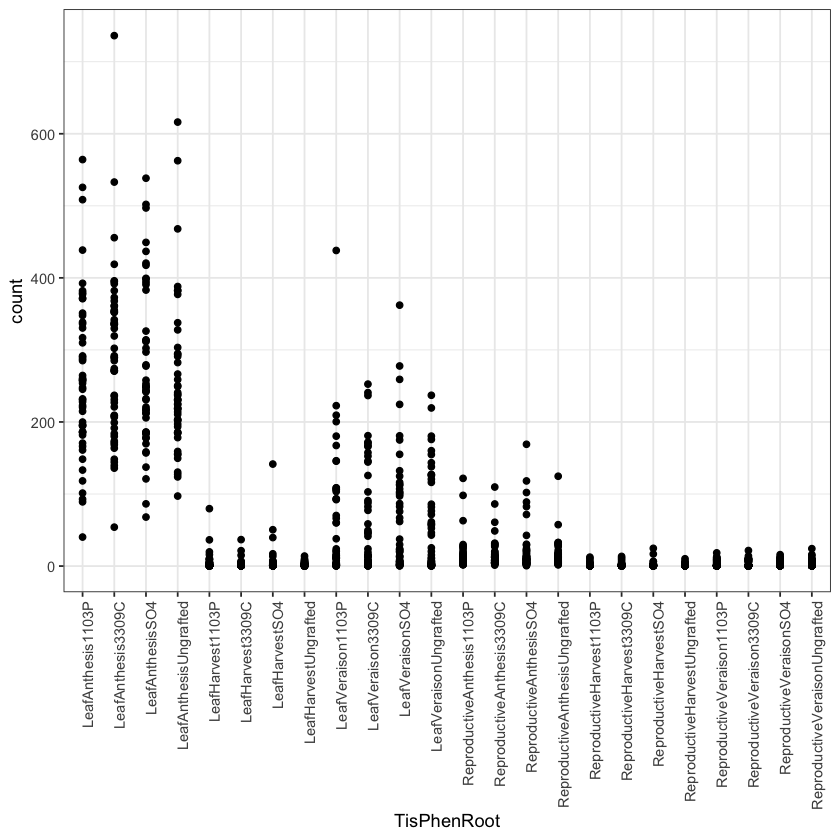

In [29]:
x <- plotCounts(dds_int, gene='Vitvi19g02322', intgroup='TisPhenRoot', returnData = TRUE)
colnames(x)

ggplot(x, aes(x=TisPhenRoot, y=count)) + 
  geom_point() + 
  theme_bw() +
  theme(axis.text.x=element_text(angle = 90, hjust = 1))

In [220]:
dds_fucked$YrRoot <- factor(paste0(dds_filt$Year, dds_filt$Rootstock))
dds_fucked$PhenoRoot <- factor(paste0(dds_filt$Phenology, dds_filt$Rootstock))
dds_fucked$TisRoot <- factor(paste0(dds_filt$Tissue, dds_filt$Rootstock))

design(dds_fucked) <- ~Block + Irrigation + PhenoRoot
design(dds_fucked)

~Block + Irrigation + PhenoRoot

In [221]:
dds_fucked <- DESeq(dds_fucked)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 109 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


In [222]:
resultsNames(dds_fucked)

[1] "Intercept"                                   
 [2] "Block_B_vs_A"                                
 [3] "Block_C_vs_A"                                
 [4] "Irrigation_RDI_vs_None"                      
 [5] "Irrigation_Full_vs_None"                     
 [6] "PhenoRoot_Anthesis3309C_vs_Anthesis1103P"    
 [7] "PhenoRoot_AnthesisSO4_vs_Anthesis1103P"      
 [8] "PhenoRoot_AnthesisUngrafted_vs_Anthesis1103P"
 [9] "PhenoRoot_Harvest1103P_vs_Anthesis1103P"     
[10] "PhenoRoot_Harvest3309C_vs_Anthesis1103P"     
[11] "PhenoRoot_HarvestSO4_vs_Anthesis1103P"       
[12] "PhenoRoot_HarvestUngrafted_vs_Anthesis1103P" 
[13] "PhenoRoot_Veraison1103P_vs_Anthesis1103P"    
[14] "PhenoRoot_Veraison3309C_vs_Anthesis1103P"    
[15] "PhenoRoot_VeraisonSO4_vs_Anthesis1103P"      
[16] "PhenoRoot_VeraisonUngrafted_vs_Anthesis1103P"

In [234]:
res <- results(dds_fucked, contrast=c('PhenoRoot', 'HarvestUngrafted', 'HarvestSO4'), lfcThreshold=0, alpha=0.05)
#res
summary(res)


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 41, 0.17%
LFC < 0 (down)     : 1089, 4.5%
outliers [1]       : 2, 0.0082%
low counts [2]     : 3307, 14%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [235]:
subset(res, padj < 0.05)

log2 fold change (MLE): PhenoRoot HarvestUngrafted vs HarvestSO4 
Wald test p-value: PhenoRoot HarvestUngrafted vs HarvestSO4 
DataFrame with 1130 rows and 6 columns
                      baseMean     log2FoldChange              lfcSE
                     <numeric>          <numeric>          <numeric>
Vitvi00g00676  20.473768026779 -0.808796323854418  0.208442931807641
Vitvi00g00936 4.28541928071918 -0.776923941431147   0.23735550887533
Vitvi00g01106 29.0203411152211 -0.656828327528563  0.185294182794017
Vitvi00g02106 3.81539472662646 -0.511593940895568   0.16633853897843
Vitvi01g00012  27.260329423679 -0.580061660129986   0.17873444111295
...                        ...                ...                ...
Vitvi19g02020 136.317596589011 -0.244145111383286 0.0777800517632222
Vitvi19g02024 680.111169276809   -2.3661413563002  0.428572697477234
Vitvi19g02085  77.558110414555 -0.461924837305673  0.132763527727975
Vitvi19g02100 5.43699232719925  -1.86663941344752  0.406057448920953
Vitvi1

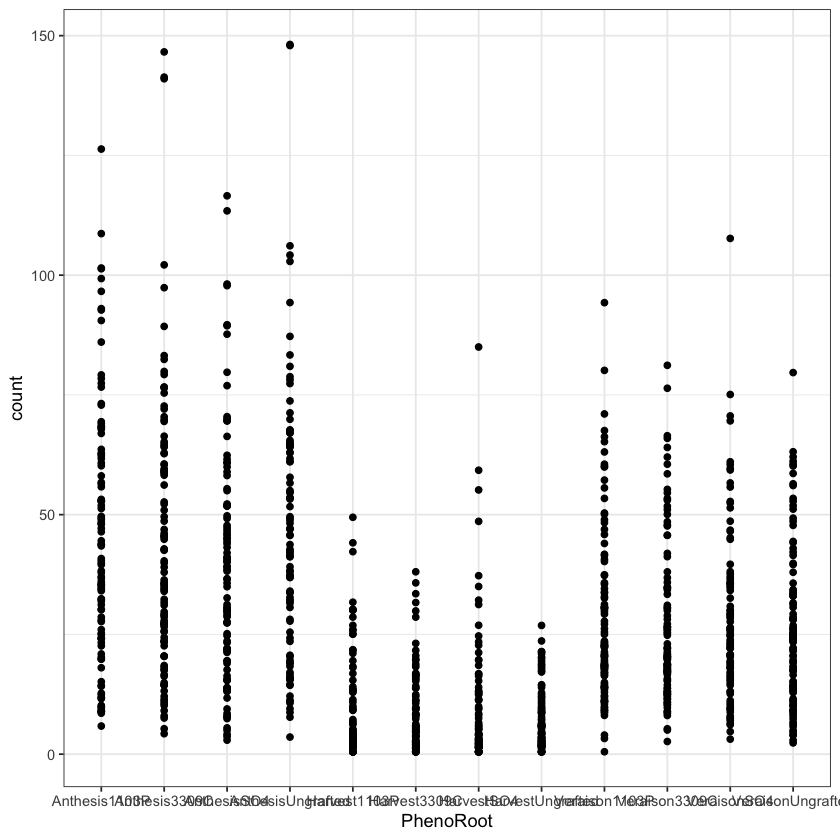

In [245]:

x <- plotCounts(dds_fucked, gene="Vitvi01g00012", intgroup='PhenoRoot', returnData=T)

pd <- position_dodge(width=0.9)
ggplot(x, aes(PhenoRoot, count)) + 
  geom_point(position = pd) +  
  theme_bw()

In [143]:
# res <- results(dds_filt, contrast=c("Tissue","Reproductive","Leaf"), lfcThreshold=0, alpha=0.05)
# #res
# summary(res)

# res <- results(dds_filt, contrast=c("Year","2018","2017"), lfcThreshold=0, alpha=0.05)
# #res
# summary(res)

# res <- results(dds_filt, contrast=c("Year","2019","2017"), lfcThreshold=0, alpha=0.05)
# #res
# summary(res)

# res <- results(dds_filt, contrast=c("Year","2019","2018"), lfcThreshold=0, alpha=0.05)
# #res
# summary(res)

# res <- results(dds_filt, contrast=c("Phenology","Veraison","Anthesis"), lfcThreshold=0, alpha=0.05)
# #res
# summary(res)

# res <- results(dds_filt, contrast=c("Phenology","Harvest","Anthesis"), lfcThreshold=0, alpha=0.05)
# #res
# summary(res)

# res <- results(dds_filt, contrast=c("Phenology","Harvest","Veraison"), lfcThreshold=0, alpha=0.05)
# #res
# summary(res)


res <- results(dds_filt, contrast=c("Rootstock","1103P","Ungrafted"), lfcThreshold=0, alpha=0.05)
#res
summary(res)


out of 24392 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 584, 2.4%
LFC < 0 (down)     : 96, 0.39%
outliers [1]       : 0, 0%
low counts [2]     : 3308, 14%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [147]:
subset(subset(res, padj < 0.05), log2FoldChange < -0.5)

log2 fold change (MLE): Rootstock 1103P vs Ungrafted 
Wald test p-value: Rootstock 1103P vs Ungrafted 
DataFrame with 22 rows and 6 columns
                       baseMean     log2FoldChange             lfcSE
                      <numeric>          <numeric>         <numeric>
Vitvi02g00226  36.2213489564059 -0.650571565674513 0.166880226575177
Vitvi02g00358 0.697885071784961 -0.597613142613772 0.173006379289392
Vitvi02g01288  62.1663024186938  -0.68482376544437 0.142233122883789
Vitvi04g01352  7.60993001492397  -1.07616351851758 0.136415081119976
Vitvi05g01337  10.3791435215094  -0.60088395621102 0.127075538245764
...                         ...                ...               ...
Vitvi12g02208  403.494363195395  -1.20344631312087 0.253603015373238
Vitvi13g02110  1.85234123099806  -1.01438390016331 0.276997452572009
Vitvi14g01469  290.281122428879 -0.619732324274133 0.188877354208965
Vitvi18g00430  2.45536218121518 -0.565960179533815 0.157658903634153
Vitvi19g02212  15.4643322502315 

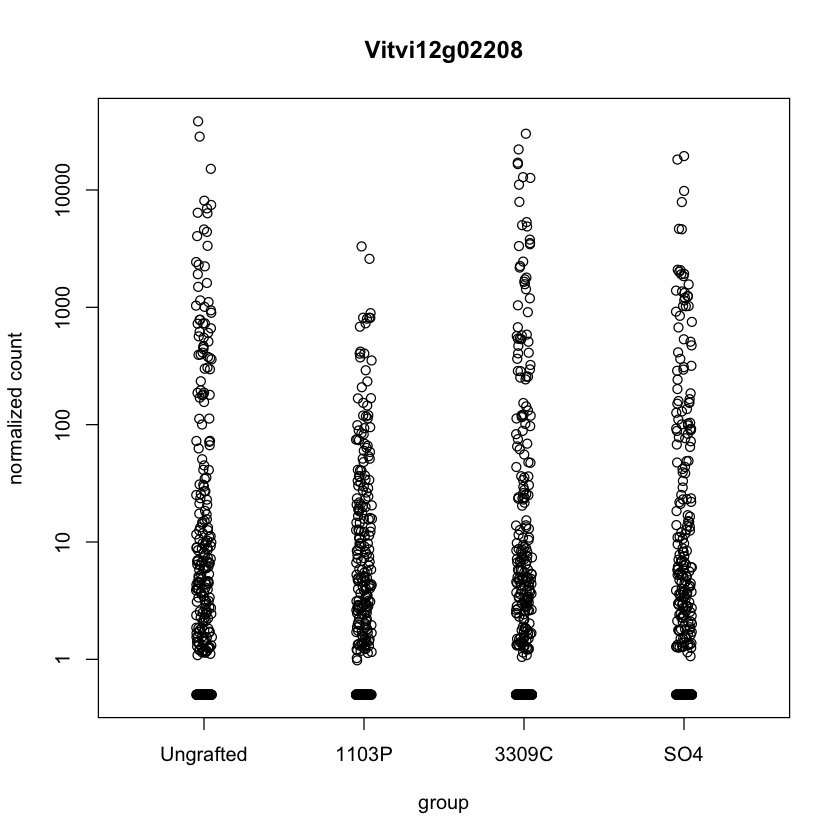

In [148]:
plotCounts(dds_filt, gene='Vitvi12g02208', intgroup="Rootstock")

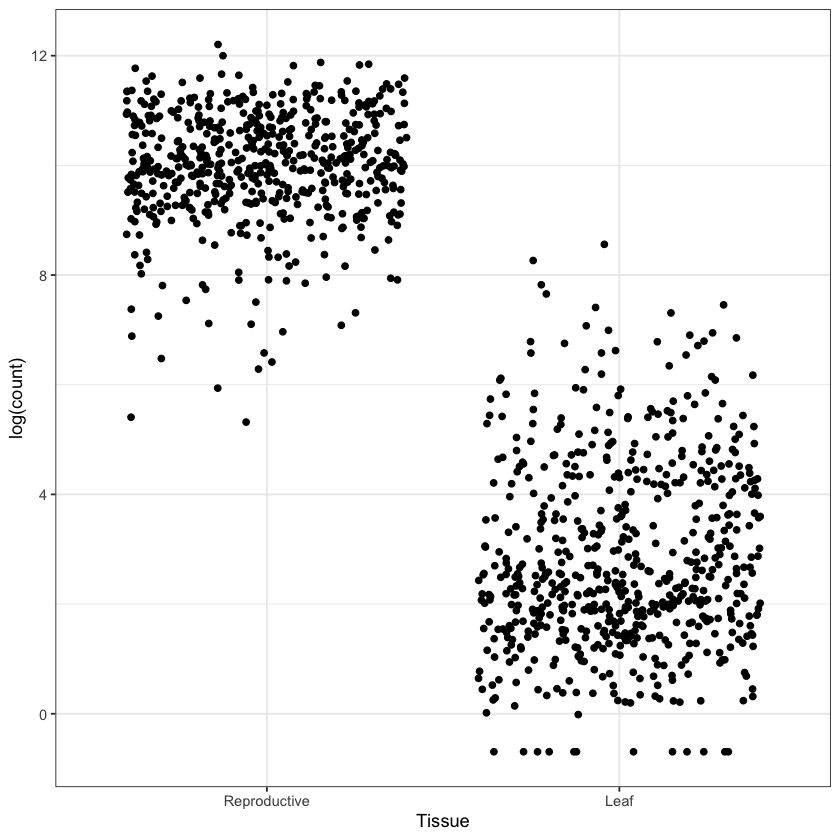

In [142]:
x <- plotCounts(dds_filt, gene='Vitvi19g02038', intgroup="Tissue", returnData = T)

ggplot(x, aes(Tissue, log(count)))+ 
  geom_jitter() + 
  theme_bw()

In [5]:
d <- data.frame(t = rnorm(100, 0, 1), 
                x1 = sample(1:3, size=100, replace=T), 
                x2 = sample(1:3, size=100, replace=T),
                x3 = sample(1:3, size=100, replace=T),
                x4 = sample(1:3, size=100, replace=T))

In [7]:
lmod <- lm(t ~ x1*x2*x3*x4, data=d)
car::Anova(lmod, type=3)

,Sum Sq,Df,F value,Pr(>F)
(Intercept),5.756017e-01,1,0.6033394845,0.43948854
x1,4.147631e-01,1,0.4347501876,0.51147089
x2,1.613571e+00,1,1.6913273917,0.19698281
x3,1.749204e+00,1,1.8334965268,0.17934682
x4,9.400118e-04,1,0.0009853102,0.97503326
x1:x2,1.202541e+00,1,1.2604907400,0.26475699
x1:x3,1.754263e+00,1,1.8388000257,0.17872579
x2:x3,3.431019e+00,1,3.5963577388,0.06134383
x1:x4,9.046167e-03,1,0.0094820955,0.92265973
x2:x4,2.503698e-01,1,0.2624349054,0.60979662
